In [92]:
# generic imports
import numpy as np
import pandas as pd
import cvxpy as cp
import math

In [96]:
# initial time step and final time under control
timeStep = 1
finalTime = 1000

# inital x sattelite (x,y,z,dx,dy,dz)
x_0 = np.array([0,0,0,0,400,1900]).reshape((6,1))

# phi matrix given time and beginning time.
def phi(t_i,t_0, n=(2*np.pi) / 96400):
    t = t_i - t_0
    return np.array([[4 - 3*math.cos(n*t), 0, 0, (1/n) * math.sin(n*t), (2/n) * (1 - math.cos(n*t)),0],
                 [6*(math.sin(n*t)-n*t),1, 0, -1*(2/n)*( 1 - math.cos(n*t)), (1/n)*(4*math.sin(n*t) - 3*n*t),0],
                 [0,0,math.cos(n*t),0,0,(1/n)*math.sin(n*t)],
                 [3*n*math.sin(n*t),0,0,math.cos(n*t),2*math.sin(n*t),0],
                 [-6*n*(1-math.cos(n*t)),0,0,-2*math.sin(n*t), 4*math.cos(n*t)-3, 0], 
                 [0,0,-1*n*math.sin(n*t), 0, 0, math.cos(n*t)]])

# find the specific velocity pebetuation that we want for a given time step.
def delt(u,i,delta):
    return np.array([[0],[0],[0],[u[i][0]*delta],[u[i][1]*delta],[u[i][2]*delta]])

# move from x_0 to x_i
def move(x_0, u, target, delta):
    x_i = phi(target, 0) @ x_0
    for j in range(1, target):
        x_i = x_i + phi(target, j) @ delt(u,j,delta)

    return x_i

def moveOneStep(x_0, u, delta, i):
    x_i = x_0 + phi(0, 1) @ delt(u,1,delta)
    return x_i

In [97]:
# define u, the vector of movements as what we are trying to minimize.
u = cp.Variable((finalTime*timeStep,3))
# define the objective function as the sum of the squares of the movements.
objective = cp.Minimize(cp.sum_squares(u))

# constraints for thie problem:
# 1. final position is (0,0,0) or very close to it.
# 2. the magnitude of every movement is less than maxPropulsion.
maxPropulsion = 100000
# 1. final position is (0,0,0) or very close to it.
constraints = [ np.sum(move(x_0, u, finalTime*timeStep, timeStep)**2) <= 0.1]

# 2. the magnitude of every movement is less than maxPropulsion.
for i in range(finalTime*timeStep):
    constraints += [(u[i][0]**2 + u[i][1]**2 + u[i][2]**2) <= maxPropulsion]

# solve the problem
prob = cp.Problem(objective, constraints)
sol = prob.solve()

print("Thrust Vectors at Final Time Step")
print(u.value)
print("Final Position")
print(move(x_0, u.value, finalTime*timeStep, timeStep))

Thrust Vectors at Final Time Step
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.26502559e-04 -1.60110574e+00 -7.60526245e+00]
 [-2.30479656e-04 -1.59870045e+00 -7.59383725e+00]
 ...
 [ 5.17308167e-02  7.95122901e-01  3.78482571e+00]
 [ 5.19611154e-02  7.97858475e-01  3.79786610e+00]
 [ 5.22161781e-02  8.00968421e-01  3.81281993e+00]]
Final Position
[[ 8.48314593e-06]
 [ 1.95075443e-04]
 [ 9.27263226e-04]
 [-4.24207682e-03]
 [-6.50057733e-02]
 [-3.09434298e-01]]


/usr/local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


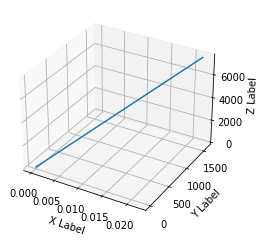

Text(0.5, 0, 'time')

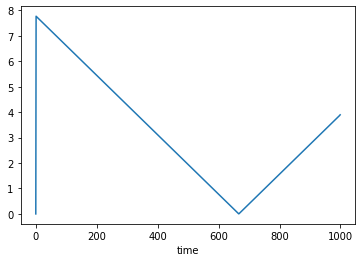

In [100]:
# plot trajectory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_trajectory = [x_0[0][0]]
y_trajectory = [x_0[1][0]]
z_trajectory = [x_0[2][0]]

x_i = x_0
# get x,y,z values for plotting
for i in range(1,finalTime*timeStep):
    x_i = moveOneStep(x_i, u.value, timeStep, i)
    # get first three elements of x_i
    x_trajectory.append(x_i[0][0])
    y_trajectory.append(x_i[1][0])
    z_trajectory.append(x_i[2][0])

# convert to numpy arrays
#x_trajectory = np.array(x_trajectory).reshape((1,finalTime*timeStep))
#y_trajectory = np.array(y_trajectory).reshape((1,finalTime*timeStep))
#z_trajectory = np.array(z_trajectory).reshape((1,finalTime*timeStep))

#print(x_trajectory)
# print sizes

# plot trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x_trajectory, y_trajectory, z_trajectory)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# plot usage of thrust magnitude at each time step
thrust = [ math.sqrt(u.value[i][0]**2 + u.value[i][1]**2 + u.value[i][2]**2) for i in range(finalTime*timeStep)]

plt.plot(thrust)
plt.xlabel('time')